This file is part of https://github.com/diehlpk/reusommer21.

Copyright (c) 2021 Patrick Diehl

This program is free software: you can redistribute it and/or modify  
it under the terms of the GNU General Public License as published by  
the Free Software Foundation, version 3.

This program is distributed in the hope that it will be useful, but 
WITHOUT ANY WARRANTY; without even the implied warranty of 
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU 
General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. 
If not, see <http://www.gnu.org/licenses/>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
example = "Quadratic"
save_results = False

In [3]:
#############################################################################
# Exact solution 
#############################################################################

def exactSolution(x):
    
    if example == "Cubic":
        return (2/3/np.sqrt(3)) * ( 9*x - 9*x*x + 2 * x * x * x )
    elif example == "Quartic":
        return 16/9 * x * x - 32/27 * x * x * x + 16/81 * x * x * x * x
    elif example == "Quadratic":
        return  4/3 * x - 4/9 * x * x
    elif example == "Linear":
        return x
    else:
        print("Error: Either provide Linear, Quadratic, Quartic, or Cubic")
        sys.exit()

In [4]:
#############################################################################
# Solve the system
#############################################################################

def solve(M,f):
    return np.linalg.solve(M,f)

In [5]:
#############################################################################
# Loading
#############################################################################

def f(x):
    
    if example == "Cubic":
        return -( 2/np.sqrt(3)) * ( -6 + 4*x )
    elif example == "Quartic":
        return  -32/9 + 64/9 * x - 64/27 * x * x
    elif example == "Quadratic":
        return 8/9
    else:
        print("Error: Either provide Quadratic, Quartic, or Cubic")
        sys.exit()

def forceFull(n,x):
    
    force = np.zeros(n)
   
    for i in range(1,n-1):
        force[i] = f(x[i])
    
    force[n-1] = 0
    
    return force

def forceCoupling(n,x):
    
    dim = 2*n + 2*n-1 + 4
    
    force = np.zeros(dim)
   
    for i in range(1,dim-1):
        force[i] = f(x[i])
    
    force[dim-1] = 0
    
    return force

In [6]:
#############################################################################
# Assemble the stiffness matrix for the finite difference model (FD)
#############################################################################

def FDM(n,h):

    M = np.zeros([n,n])

    M[0][0] = 1

    for i in range(1,n-1):
        M[i][i-1] = -2
        M[i][i] = 4
        M[i][i+1] = -2

    M[n-1][n-1] = 1

    M *= 1./(2.*h*h)

    return M

In [7]:
#############################################################################
# Assemble the stiffness matrix for the coupling of FDM - MSCM - FDM
#############################################################################

def CouplingMSCM(n,h,x):

    fVHM = 1./(8.*h/2*h/2)
    fFDM = 1./(2.*h*h)
    
    dim = 2*n + 2*n-1 + 4
    
    M = np.zeros([dim,dim])
    
    M[0][0] = 1 

    for i in range(1,n-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM 
    
    print(x[n-1],x[n-2],x[n-3],x[n-4])
    
    #M[n-1][n-4] = -2/6 / h
    #M[n-1][n-3] = 9/6 / h
    #M[n-1][n-2] = -18/6 / h
    #M[n-1][n-1] = 11/6 / h
    M[n-1][n-1] = 1
    
    M[n-1][n+2] = -1
    #M[n-1][n+2] = 11/6 / h *2
    #M[n-1][n+3] = -18/6 / h *2
    #M[n-1][n+4] = 9/6 / h *2
    #M[n-1][n+5] = -2/6 / h * 2  
    
    print(x[n+2],x[n+3],x[n+4],x[n+5])
    print("-----")
    
    print(x[n],x[n+1],x[n+2],x[n+3])
    
    M[n][n+3] = -2/6 / h * 2
    M[n][n+2] = 9/6 / h * 2
    M[n][n+1] = -18/6 / h * 2
    M[n][n] = 11/6 / h * 2
 
    M[n][n-2] =  11/6 / h 
    M[n][n-3] = -18/6 / h 
    M[n][n-4] = 9/6 / h 
    M[n][n-5] = -2/6 / h 
    
    print(x[n-2],x[n-3],x[n-4],x[n-5])
    print("-----")
    
    M[n+1][n+1] = -1
    M[n+1][n-3] = -1/8
    M[n+1][n-2] = 3/4
    M[n+1][n-1] = 3/8
    
    print(x[n+1],x[n-1],x[n-2],x[n-3])
    print("-----")
    
         
    mid = n+2*n+1
    
    for i in range(n+2,mid):
        M[i][i-2] = -1. * fVHM
        M[i][i-1] = -4. * fVHM
        M[i][i] = 10. * fVHM
        M[i][i+1] =  -4. * fVHM
        M[i][i+2] = -1. * fVHM
         
    print(x[mid],x[mid+2],x[mid+3],x[mid+4])        
    print("-----")
    
    M[mid][mid] = -1
    M[mid][mid+2] = 3/8 
    M[mid][mid+3] = 3/4
    M[mid][mid+4] = -1/8
    
    print(x[mid+1],x[mid],x[mid-1],x[mid-2])      
        
    M[mid+1][mid-2] = -2/6 / h * 2
    M[mid+1][mid-1] = 9/6 / h * 2
    M[mid+1][mid] = -18/6 / h * 2
    M[mid+1][mid+1] = 11/6 / h * 2
    
    print(x[mid+3],x[mid+4],x[mid+5],x[mid+6])        
    print("-----")
    
    M[mid+1][mid+3] = 11/6 / h
    M[mid+1][mid+4] = -18/6 / h 
    M[mid+1][mid+5] = 9/6 / h
    M[mid+1][mid+6] = -2/6 / h
    
    print(x[mid-1],x[mid-2],x[mid-3],x[mid-4])
    
    #M[mid+2][mid-4] = -2/6 / h * 2
    #M[mid+2][mid-3] =  9/6 / h * 2
    #M[mid+2][mid-2] = -18/6 / h * 2
    #M[mid+2][mid-1] = 11/6 / h * 2
    M[mid+2][mid-1] = 1
    
    print(x[mid+2],x[mid+3],x[mid+4],x[mid+5])
    
    M[mid+2][mid+2] = -1
    #M[mid+2][mid+2] = 11/6 / h
    #M[mid+2][mid+3] = -18/6 / h 
    #M[mid+2][mid+4] = 9/6 / h
    #M[mid+2][mid+5] = -2/6 / h
    
    for i in range(mid+3,dim-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM

    M[dim-1][dim-1] = 1
        
    return M

In [8]:
def compute(i):
    
    n = np.power(2,int(i))
    h = 1./n
    nodes = n + 1
    
    print(nodes,h)
    x1 = np.linspace(0,1,nodes)
    x2 = np.linspace(1-2*h/2,2.+2*h/2,2*nodes-1+4)
    x3 = np.linspace(2,3.,nodes)
    x = np.array(np.concatenate((x1,x2,x3)))
    
    #print(x)
  
    M = CouplingMSCM(nodes,h,x)
    
    f = forceCoupling(nodes,x)
    
    f[n] = 0
    f[n+1] = 0
    f[n+2] = 0
    
    mid = n+2*n+3
     
    f[mid+1] = 0
    f[mid+2] = 0
    f[mid+3] = 0
    
    u = solve(M,f)
      
    x1 = x[0:nodes]
    x2 = x[nodes+3:mid+1]
    x3 = x[mid+4:len(x)]
    
    u1 = u[0:nodes]
    u2 = u[nodes+3:mid+1]
    u3 = u[mid+4:len(x)]
    
    x = np.concatenate([x1,x2,x3])
    u = np.concatenate([u1,u2,u3])
    
    plt.plot(x,u,label="$hFD=$"+str(h))
    plt.grid(True)
    
    x = np.arange(0,3+h/2,h/2)
    interval = int(len(x)/3)
    
    forceFD = forceFull(len(x),x)
    MFD = FDM(len(x),h/2)
    
    uFM = solve(MFD,forceFD)
    
    print(len(uFM),len(x))
    
    x1 = x[0:interval:2]
    x2 = x[interval:2*interval]
    x3 = x[2*interval:len(x):2]
    x = np.concatenate([x1,x2,x3])
    
    uFD1 = uFM[0:interval:2]
    uFD2 = uFM[interval:2*interval]
    uFD3 = uFM[2*interval:len(uFM):2]
    uFD = np.concatenate([uFD1,uFD2,uFD3])
    
    print(len(uFD),len(x))
    
    if save_results:
        np.savetxt("x_"+str(n)+".csv", x, delimiter=",")
        np.savetxt("u_mscm_d_"+str(n)+".csv", u, delimiter=",")

    
    return u , uFD , x

17 0.0625
1.0 0.9375 0.875 0.8125
1.0 1.03125 1.0625 1.09375
-----
0.9375 0.96875 1.0 1.03125
0.9375 0.875 0.8125 0.75
-----
0.96875 1.0 0.9375 0.875
-----
2.03125 2.0 2.0625 2.125
-----
2.0625 2.03125 2.0 1.96875
2.0625 2.125 2.1875 2.25
-----
2.0 1.96875 1.9375 1.90625
2.0 2.0625 2.125 2.1875
97 97
65 65
33 0.03125
1.0 0.96875 0.9375 0.90625
1.0 1.015625 1.03125 1.046875
-----
0.96875 0.984375 1.0 1.015625
0.96875 0.9375 0.90625 0.875
-----
0.984375 1.0 0.96875 0.9375
-----
2.015625 2.0 2.03125 2.0625
-----
2.03125 2.015625 2.0 1.984375
2.03125 2.0625 2.09375 2.125
-----
2.0 1.984375 1.96875 1.953125
2.0 2.03125 2.0625 2.09375
193 193
129 129
65 0.015625
1.0 0.984375 0.96875 0.953125
1.0 1.0078125 1.015625 1.0234375
-----
0.984375 0.9921875 1.0 1.0078125
0.984375 0.96875 0.953125 0.9375
-----
0.9921875 1.0 0.984375 0.96875
-----
2.0078125 2.0 2.015625 2.03125
-----
2.015625 2.0078125 2.0 1.9921875
2.015625 2.03125 2.046875 2.0625
-----
2.0 1.9921875 1.984375 1.9765625
2.0 2.015625 2.

Text(0.5, 1.0, 'Quadratic solution ')

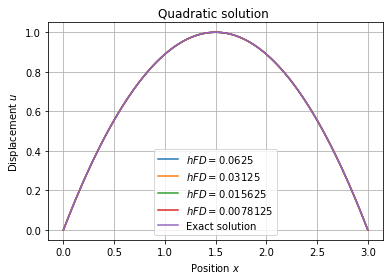

In [9]:
uCoupled = []
uLocal = []
xLocal = []
max_iteration = 8

for i in range(4,max_iteration):
    u , uFD , x = compute(i)
    uCoupled.append(u)
    uLocal.append(uFD)
    xLocal.append(x)

n = np.power(2,int(max_iteration))
h = 1./n

x = np.arange(0,3+h,h)
plt.plot(x,exactSolution(x),label="Exact solution")#
plt.legend()
plt.xlabel(r"Position $x$")
plt.ylabel(r"Displacement $u$")
plt.title(example+" solution ")
#plt.savefig("coupling-vhm-"+str(example)+"-dirchelt.pdf")

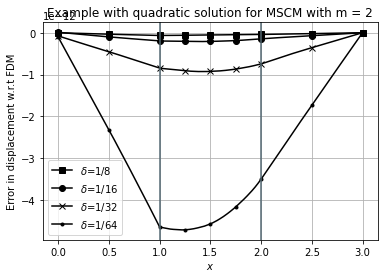

In [10]:
plt.clf()
markers = ['s','o','x','.']
level = [8,16,32,64]

for i in range(0,len(xLocal)):
    n = np.power(2,i+4)
    plt.plot(xLocal[i],uLocal[i]-uCoupled[i],color="black",marker=markers[i],markevery=level[i],label=r"$\delta$=1/"+str(int(n/2)))
    
plt.xlabel(r"$x$")
plt.ylabel(r"Error in displacement w.r.t FDM")
plt.title(r"Example with " + str(example).lower() + " solution for MSCM with m = 2")
plt.grid()
plt.axvline(x=1,c="#536872")
plt.axvline(x=2,c="#536872")
plt.legend()
plt.savefig("coupling-MSCM-"+str(example)+"-dirchelt-error.pdf",bbox_inches='tight')